<form action="index.ipynb">
    <input type="submit" value="Return to Index" style="background-color: green; color: white; width: 150px; height: 35px; float: right"/>
</form>

# Landau Energy - Multidimensional X-data Example
Author(s): Paul Miles | Date Created: July 18, 2019

This example demonstrates using [pymcmcstat](https://github.com/prmiles/pymcmcstat/wiki) with multidimensional input spaces, e.g. functions that depend on two-spatial variables such as $x_1$ and $x_2$.  For this particular problem we consider a 6th order Landau energy function, which is used in a wide variety of material science applications.  

Consider the 6th order Landau function:

$$ u(q;{\bf P}) = \alpha_{1}(P_1^2+P_2^2+P_3^2) + \alpha_{11}(P_1^2 + P_2^2 + P_3^2)^2 + \alpha_{111}(P_1^6 + P_2^6 + P_3^6) + \alpha_{12}(P_1^2P_2^2 + P_1^2P_3^2 + P_2^2P_3^2) + \alpha_{112}(P_1^4(P_2^2 + P_3^2) + P_2^4(P_1^2 + P_3^2) + P_3^4(P_1^2 + P_2^2)) + \alpha_{123}P_1^2P_2^2P_3^2$$

where $q = [\alpha_{1},\alpha_{11},\alpha_{111},\alpha_{12},\alpha_{112},\alpha_{123}]$. The Landau energy is a function of 3-dimensional polarization space.  For the purpose of this example, we consider the case where $P_1 = 0$.

Often times we are interested in using information calculated from Density Functional Theory (DFT) calculations in order to inform our continuum approximations, such as our Landau function.  For this example, we will assume we have a set of energy calculations corresponding to different values of $P_2$ and $P_3$ which were found using DFT. For more details regarding this type of research, the reader is referred to:

- Miles, P. R., Leon, L. S., Smith, R. C., Oates, W. S. (2018). Analysis of a Multi-Axial Quantum Informed Ferroelectric Continuum Model: Part 1—Uncertainty Quantification. Journal of Intelligent Material Systems and Structures, 29(13), 2823-2839. https://doi.org/10.1177/1045389X18781023
- Leon, L. S., Smith, R. C., Oates, W. S., Miles, P. R. (2018). Analysis of a Multi-Axial Quantum Informed Ferroelectric Continuum Model: Part 2—Sensitivity Analysis. Journal of Intelligent Material Systems and Structures, 29(13), 2840-2860. https://doi.org/10.1177/1045389X18781024

In [1]:
# import required packages
import numpy as np
from pymcmcstat.MCMC import MCMC
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn as sns
import mcmcplot.mcmatplot as mcmpl
import mcmcplot.mcseaborn as mcsbn
import scipy.io as sio
import pymcmcstat
print(pymcmcstat.__version__)

1.9.0rc2


Define the Landau energy function.

In [12]:
def landau_energy(q, data):
    P = data.xdata[0]
    a1, a11, a111, a12, a112, a123 = q
    u = a1*((P**2).sum(axis = 1)) + a11*((P**2).sum(axis = 1))**2 + a111*((P**6).sum(axis = 1))
    u += a12*(P[:,0]**2*P[:,1]**2 + P[:,0]**2*P[:,2]**2 + P[:,1]**2*P[:,2]**2)
    u += a112*(P[:,0]**4*(P[:,1]**2 + P[:,2]**2) + P[:,1]**4*(P[:,0]**2 + P[:,2]**2) + P[:,2]**4*(P[:,0]**2 + P[:,1]**2))
    u += a123*P[:,0]**2*P[:,1]**2*P[:,2]**2
    return u

We can generate a grid in the $P_2-P_3$ space in order to visualize the model response.  The model is evaluated at a particular set of parameter values, and the surface plot shows the general behavior of the energy function.

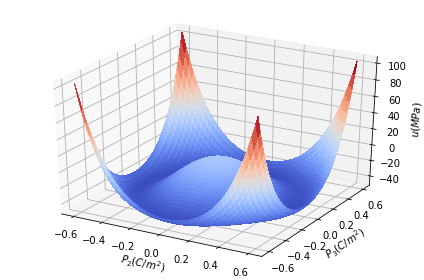

In [14]:
# Make data.
P2 = np.linspace(-0.6, 0.6, 100) #np.arange(-0.6, 0.6, 0.25)
P3 = np.linspace(-0.6, 0.6, 100) #np.arange(-0.6, 0.6, 0.25)
P2, P3 = np.meshgrid(P2, P3)
nr, nc = P2.shape
P = np.concatenate((np.zeros([nr*nc,1]), P2.flatten().reshape(nr*nc,1), P3.flatten().reshape(nr*nc,1)), axis = 1)
q = [-389.4, 761.3, 61.46, 414.1, -740.8, 0.]

from pymcmcstat.MCMC import DataStructure
data = DataStructure()
data.add_data_set(
    x=P,
    y=None)
Z = landau_energy(q, data)

# Plot the surface.
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(P2, P3, Z.reshape([nr,nc]), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.xlabel('$P_2 (C/m^2)$')
plt.ylabel('$P_3 (C/m^2)$')
ax.set_zlabel('$u (MPa)$')
plt.tight_layout()

# DFT Data
We define a set of energy results based on a series of DFT calculations which correspond to specific polarization values.

In [15]:
pdata = sio.loadmat('data_files/dft_polarization.mat')
polarization = []
for ii, pp in enumerate(pdata['polarization']):
    polarization.append(np.zeros([pp[0].shape[0], 3]))
    polarization[-1][:,1:] = pp[0]
    if ii == 0:
        polarization_array = polarization[-1]
    else:
        polarization_array = np.concatenate((polarization_array, polarization[-1]), axis = 0)
            

edata = sio.loadmat('data_files/dft_energy.mat')
energy = []
for ii, ee in enumerate(edata['energy']):
    energy.append(np.zeros([ee[0].shape[0],1]))
    energy[-1][:,:] = ee[0]*1e3 # scale to MPa
    if ii == 0:
        energy_array = energy[-1]
    else:
        energy_array = np.concatenate((energy_array, energy[-1]), axis = 0)

dft = dict(energy = energy, polarization = polarization)

from pymcmcstat.MCMC import DataStructure
data = DataStructure()
data.add_data_set(
    x=polarization_array,
    y=energy_array)

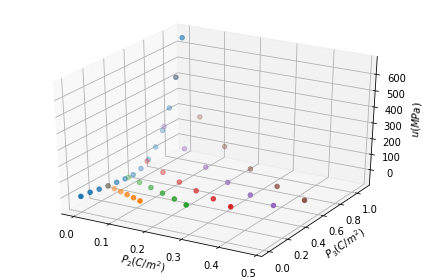

In [16]:
# Plot the surface.
fig = plt.figure()
ax = fig.gca(projection='3d')
for ii, (pp, ee) in enumerate(zip(dft['polarization'], dft['energy'])):
    ax.scatter(pp[:,1], pp[:,2], ee)
plt.xlabel('$P_2 (C/m^2)$')
plt.ylabel('$P_3 (C/m^2)$')
ax.set_zlabel('$u (MPa)$')
plt.tight_layout()

# MCMC Simulation
First we define our sum-of-squares function

In [22]:
def ssfun(q, data):
    ud = data.ydata[0]
    um = landau_energy(q, data)
    ss = ((ud - um.reshape(ud.shape))**2).sum()
    return ss

## Initialize MCMC Object
We then initialize the MCMC object and define the components:

- data structure
- parameters
- simulation options
- model settings

In [23]:
# Initialize MCMC object
mcstat = MCMC()
# setup data structure for dram
mcstat.data = data
# setup model parameters
mcstat.parameters.add_model_parameter(
    name = '$\\alpha_{1}$',
    theta0 = q[0],
    minimum = -1e8,
    maximum = 1e8,
)
mcstat.parameters.add_model_parameter(
    name = '$\\alpha_{11}$',
    theta0 = q[1],
    minimum = -1e8,
    maximum = 1e8,
)
mcstat.parameters.add_model_parameter(
    name='$\\alpha_{111}$',
    theta0=q[2],
    minimum=-1e8,
    maximum=1e8
)
mcstat.parameters.add_model_parameter(
    name='$\\alpha_{12}$',
    theta0=q[3],
    minimum=-1e8,
    maximum=1e8
)
mcstat.parameters.add_model_parameter(
    name='$\\alpha_{112}$',
    theta0=q[4],
    minimum=-1e8,
    maximum=1e8
)
mcstat.parameters.add_model_parameter(
    name='$\\alpha_{123}$',
    theta0=q[5],
    sample=False, # do not sample this parameter
)

# define simulation options
mcstat.simulation_options.define_simulation_options(
    nsimu=int(5e5),
    updatesigma=True,
    method='dram',
    adaptint=100,
    verbosity=1,
    waitbar=1,
    save_to_json=False,
    save_to_bin=False,
)

# define model settings
mcstat.model_settings.define_model_settings(
    sos_function=ssfun,
    N0=1,
    N=polarization_array.shape[0],
)

## Run MCMC Simulation & Display Stats

In [24]:
# Run mcmcrun
mcstat.run_simulation()

results = mcstat.simulation_results.results
# specify burnin period
burnin = int(results['nsimu']/2)
# display chain statistics
chain = results['chain']
s2chain = results['s2chain']
sschain = results['sschain']
names = results['names']
mcstat.chainstats(chain[burnin:,:], results)
print('Acceptance rate: {:6.4}%'.format(100*(1 - results['total_rejected'])))
print('Model Evaluations: {}'.format(results['nsimu'] - results['iacce'][0] + results['nsimu']))


Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
$\alpha_{1}$:   -389.40 [-1.00e+08,  1.00e+08] N( 0.00e+00,      inf)
$\alpha_{11}$:    761.30 [-1.00e+08,  1.00e+08] N( 0.00e+00,      inf)
$\alpha_{111}$:     61.46 [-1.00e+08,  1.00e+08] N( 0.00e+00,      inf)
$\alpha_{12}$:    414.10 [-1.00e+08,  1.00e+08] N( 0.00e+00,      inf)
$\alpha_{112}$:   -740.80 [-1.00e+08,  1.00e+08] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 500000 of 500000 complete in 207.1 sec

------------------------------
name      :       mean        std     MC_err        tau     geweke
$\alpha_{1}$:  -389.6170    10.5062     0.0927    15.5736     1.0000
$\alpha_{11}$:   761.9768    29.8714     0.2603    15.7412     0.9998
$\alpha_{111}$:    61.0143    19.8116     0.1710    15.7207     0.9984
$\alpha_{12}$:   419.0319   236.9199     2.1500    15.2299     0.9925
$\alpha_{112}$:  -753.2344   488.7210     4.5091    15.3245     0.9837
----------------

## Plot MCMC Diagnostics

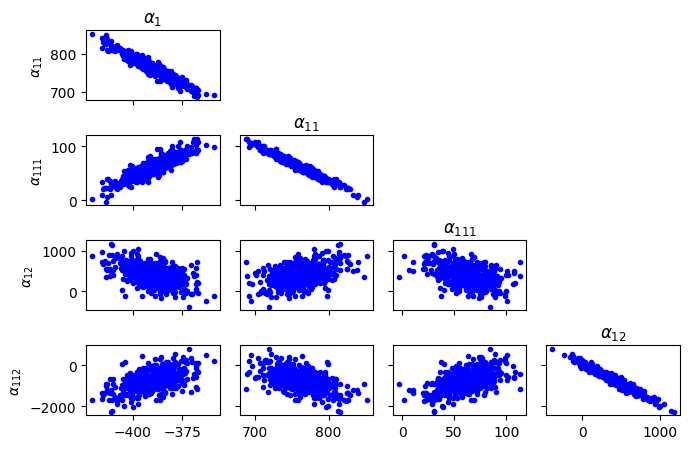

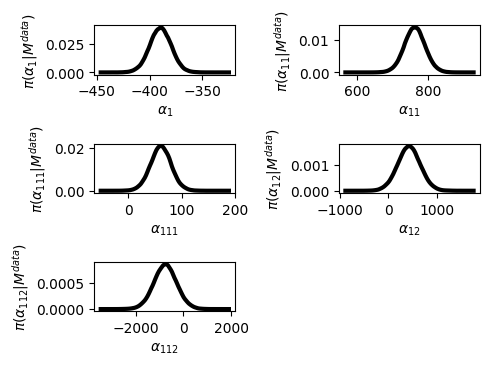

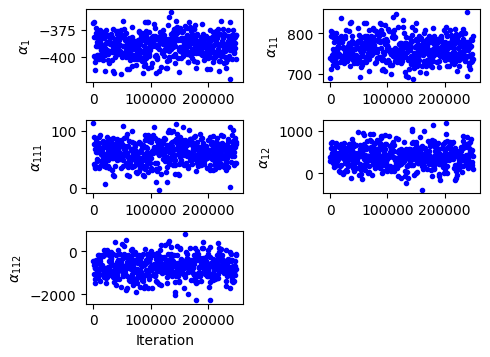

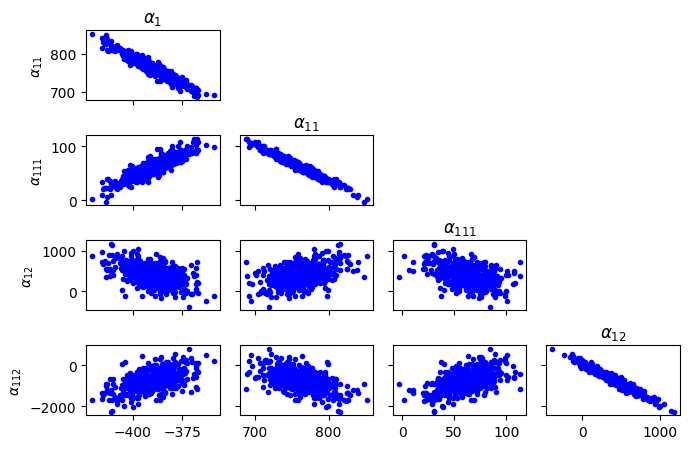

In [10]:
# generate mcmc plots
mcmpl.plot_density_panel(chain[burnin:,:], names)
mcmpl.plot_chain_panel(chain[burnin:,:], names)
mcmpl.plot_pairwise_correlation_panel(chain[burnin:,:], names)

# Generate and Plot Credible/Prediction Intervals

 [-----------------100%-----------------] 500 of 500 complete in 0.0 sec

<IPython.core.display.Javascript object>


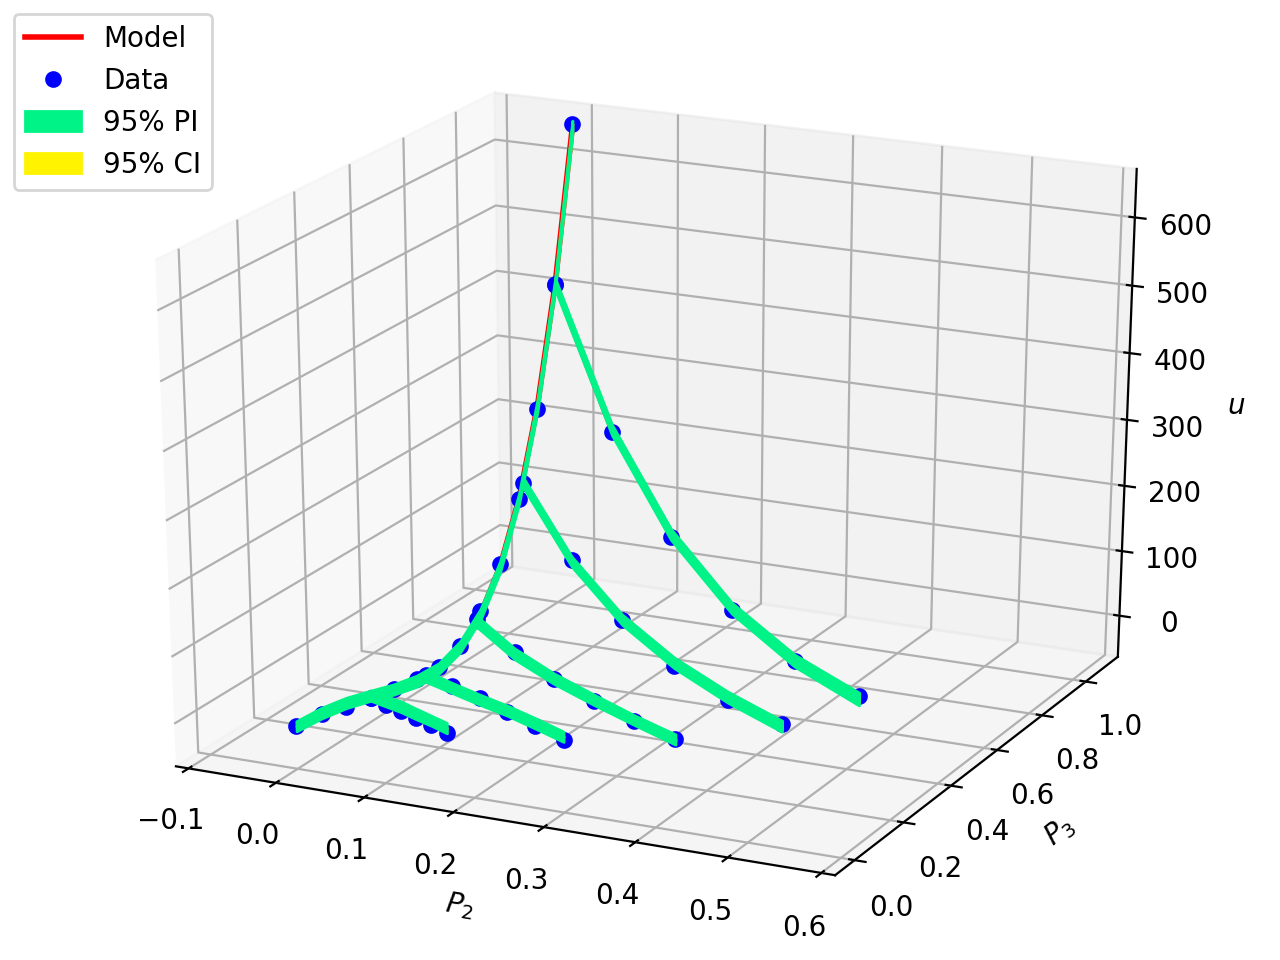

<IPython.core.display.Javascript object>


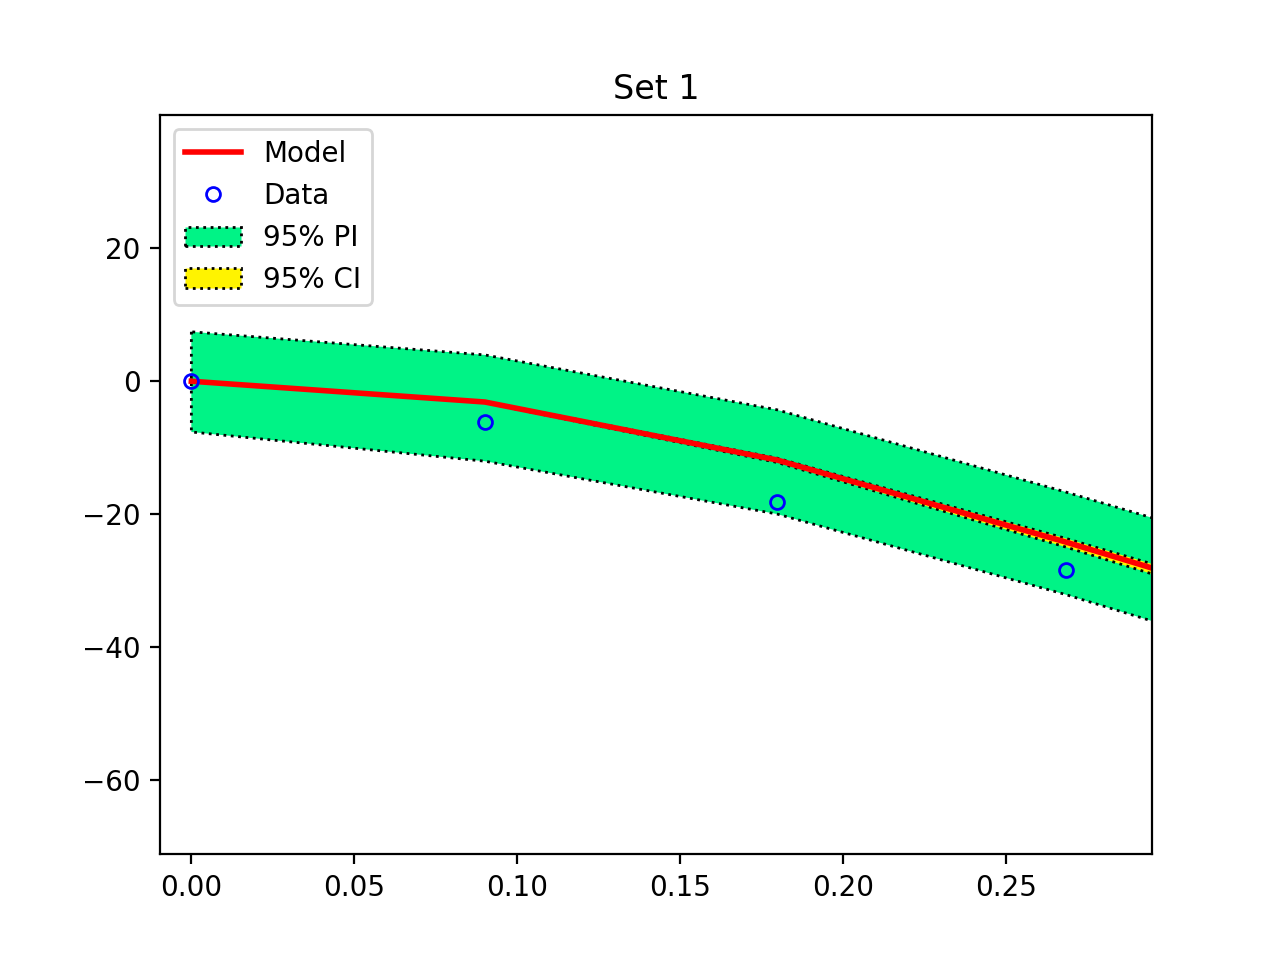

 [-----------------100%-----------------] 500 of 500 complete in 0.0 sec

<IPython.core.display.Javascript object>


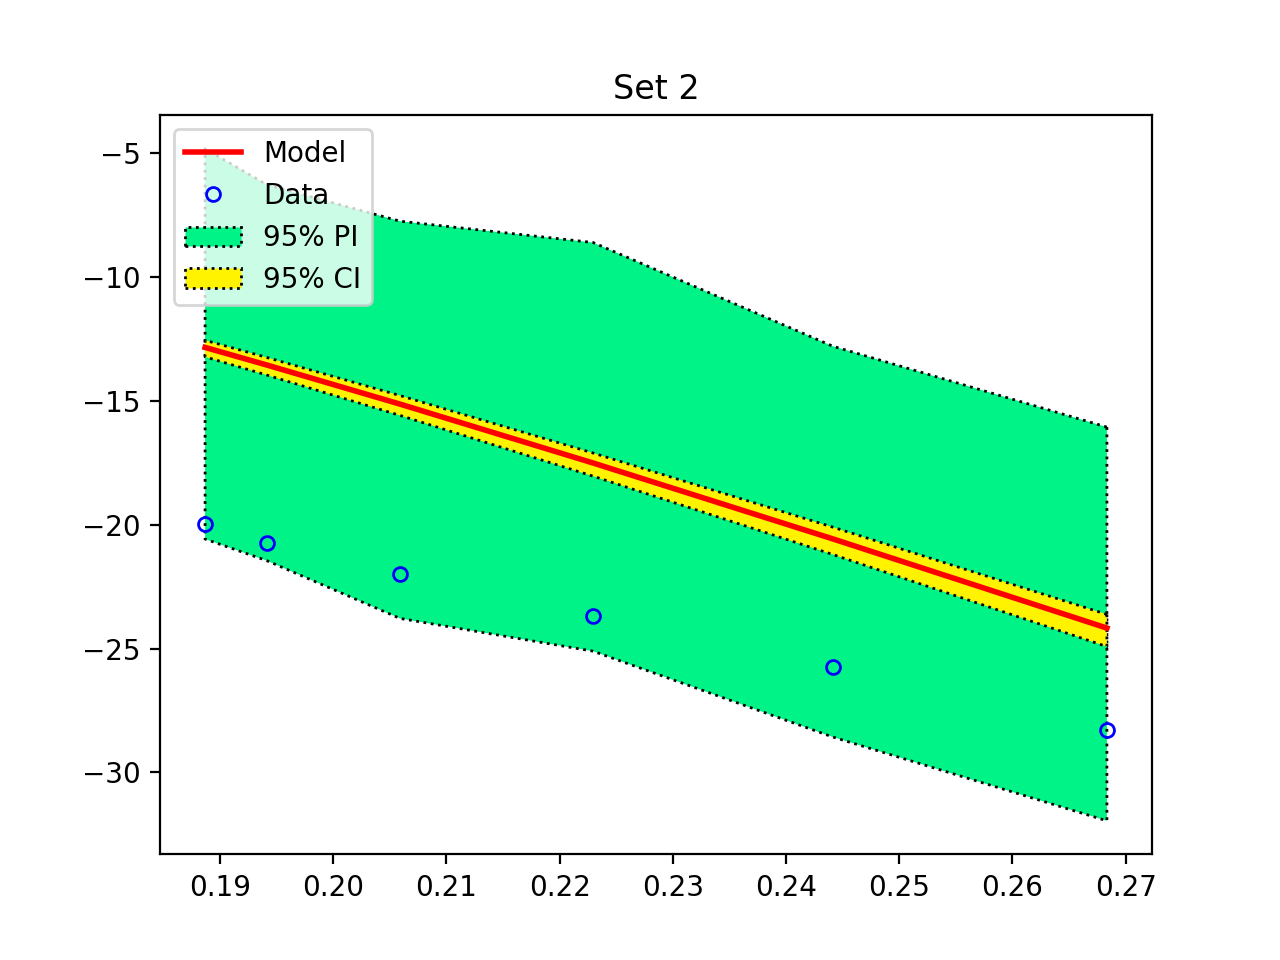

 [-----------------100%-----------------] 500 of 500 complete in 0.1 sec

<IPython.core.display.Javascript object>


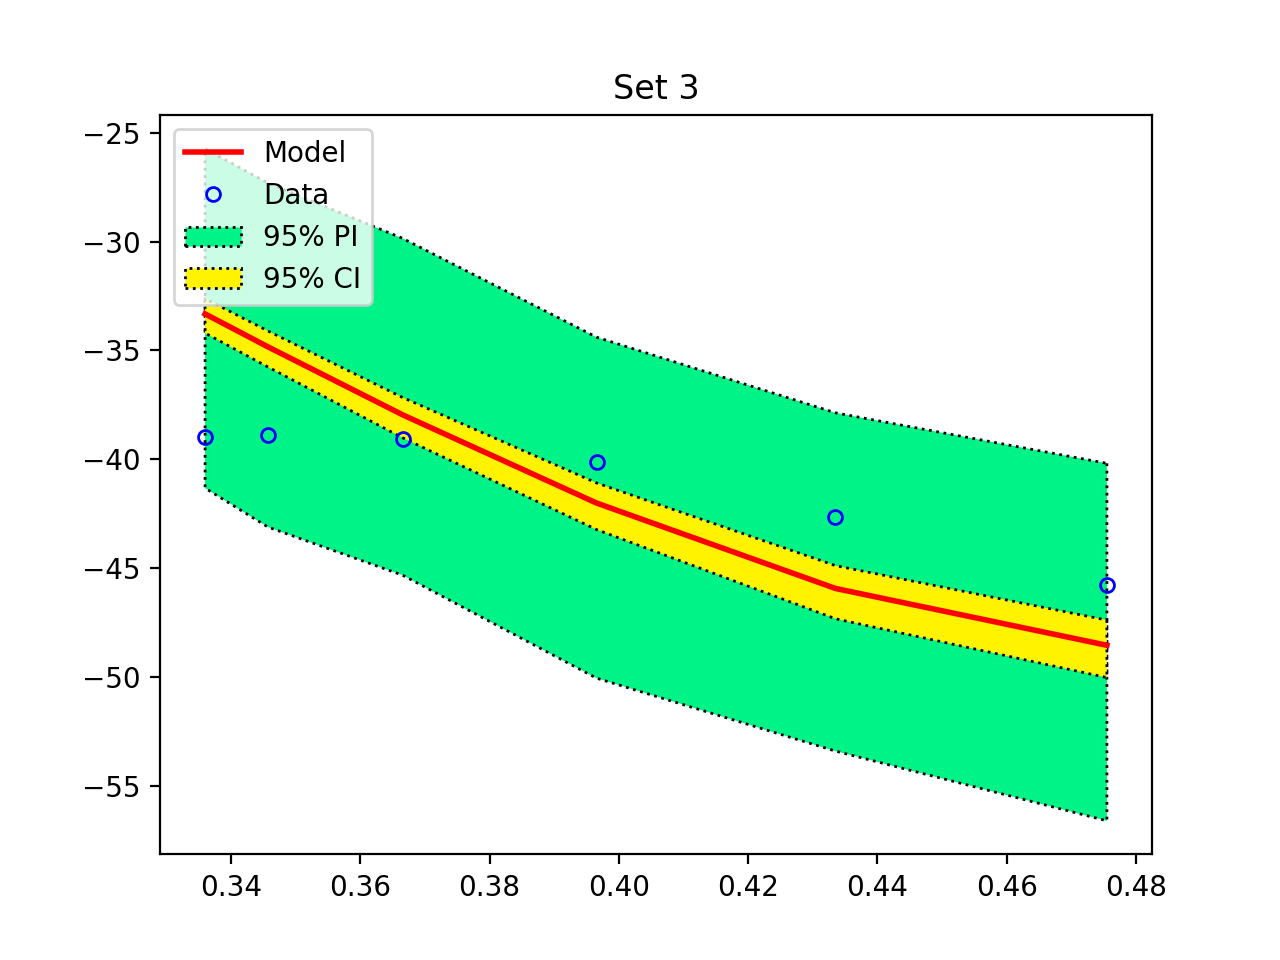

 [-----------------100%-----------------] 500 of 500 complete in 0.1 sec

<IPython.core.display.Javascript object>


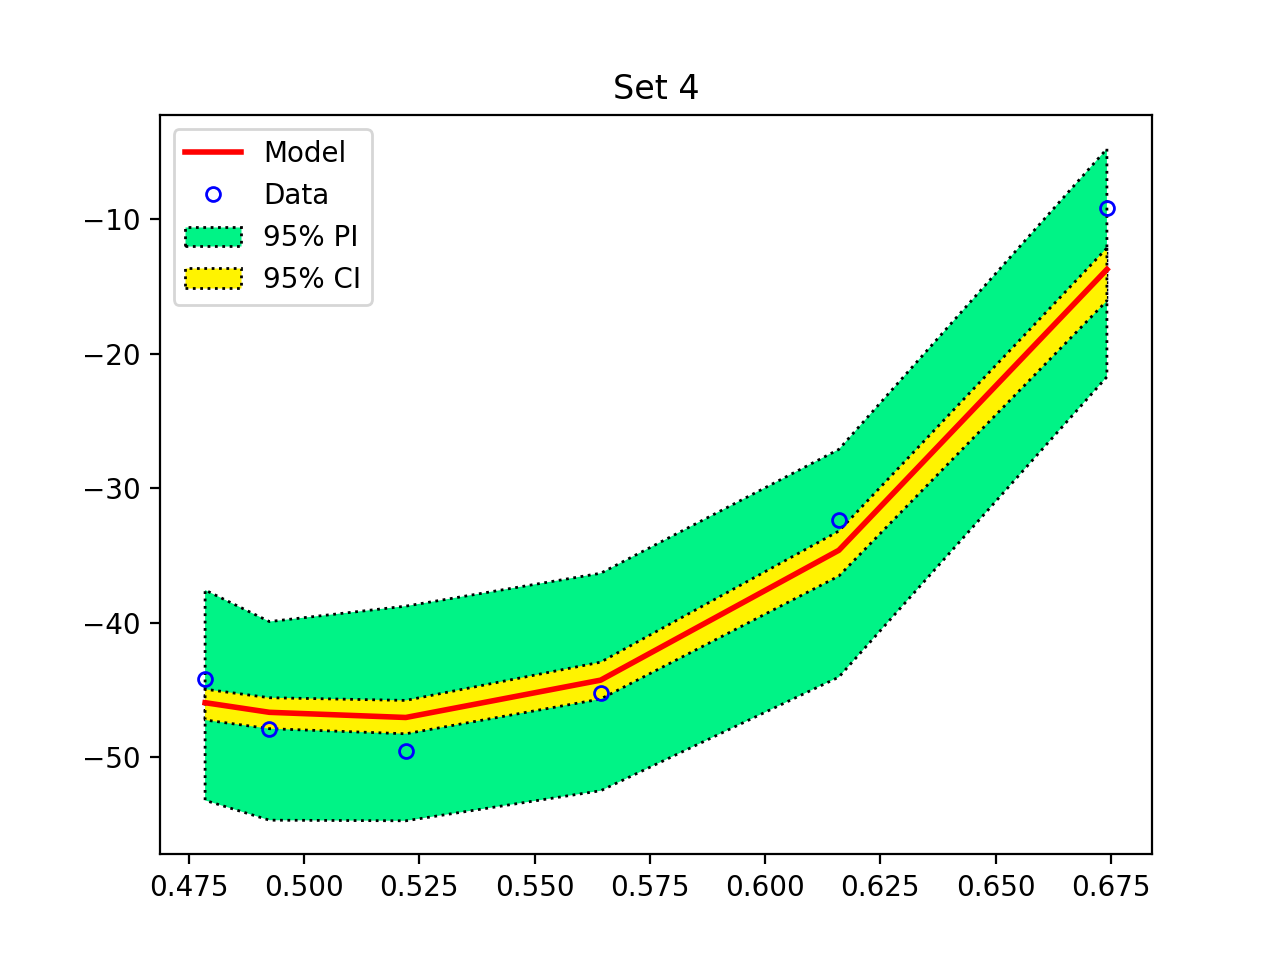

 [-----------------100%-----------------] 500 of 500 complete in 0.0 sec

<IPython.core.display.Javascript object>


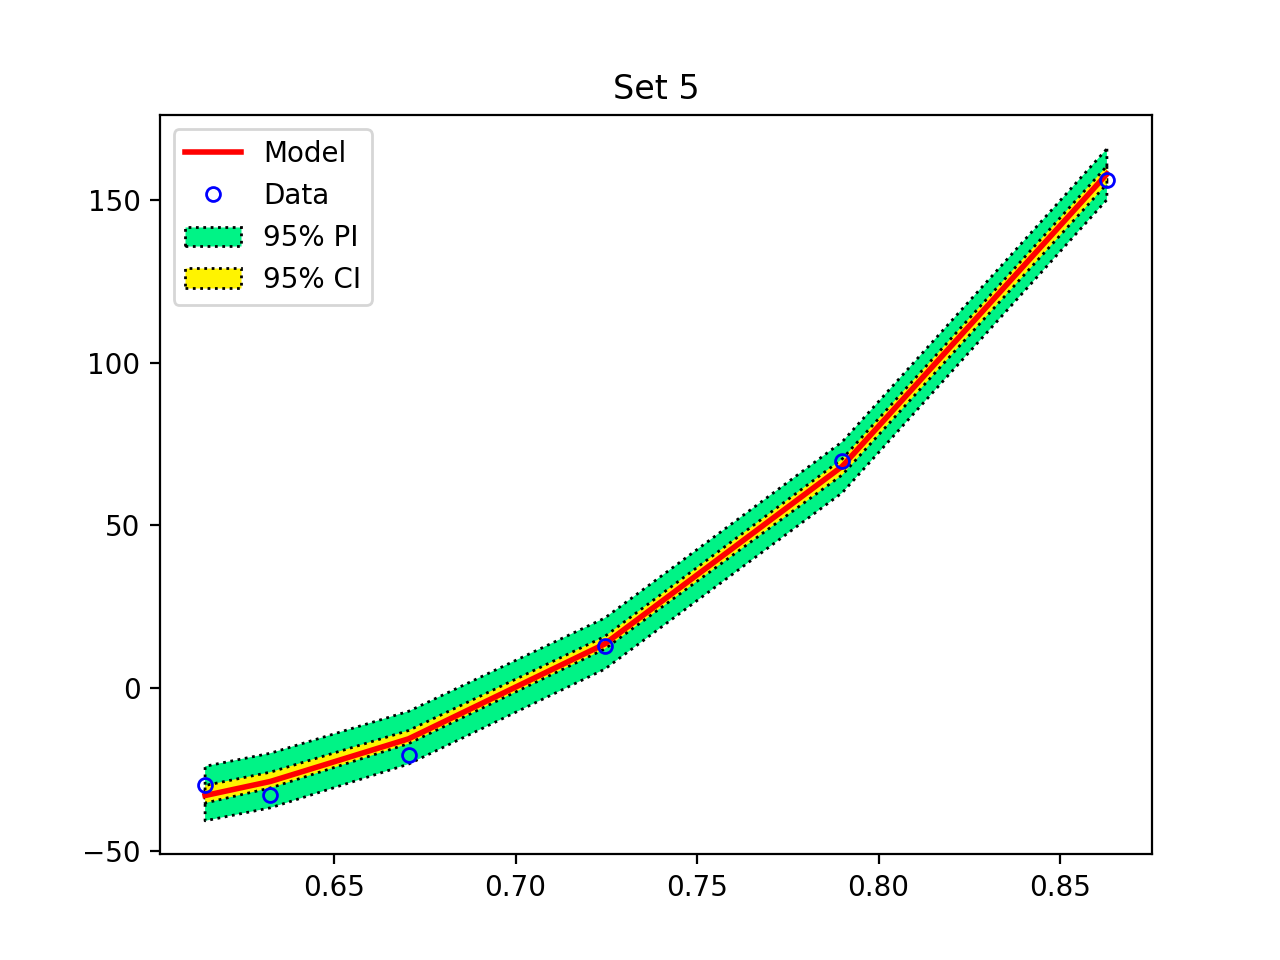

 [-----------------100%-----------------] 500 of 500 complete in 0.0 sec

<IPython.core.display.Javascript object>


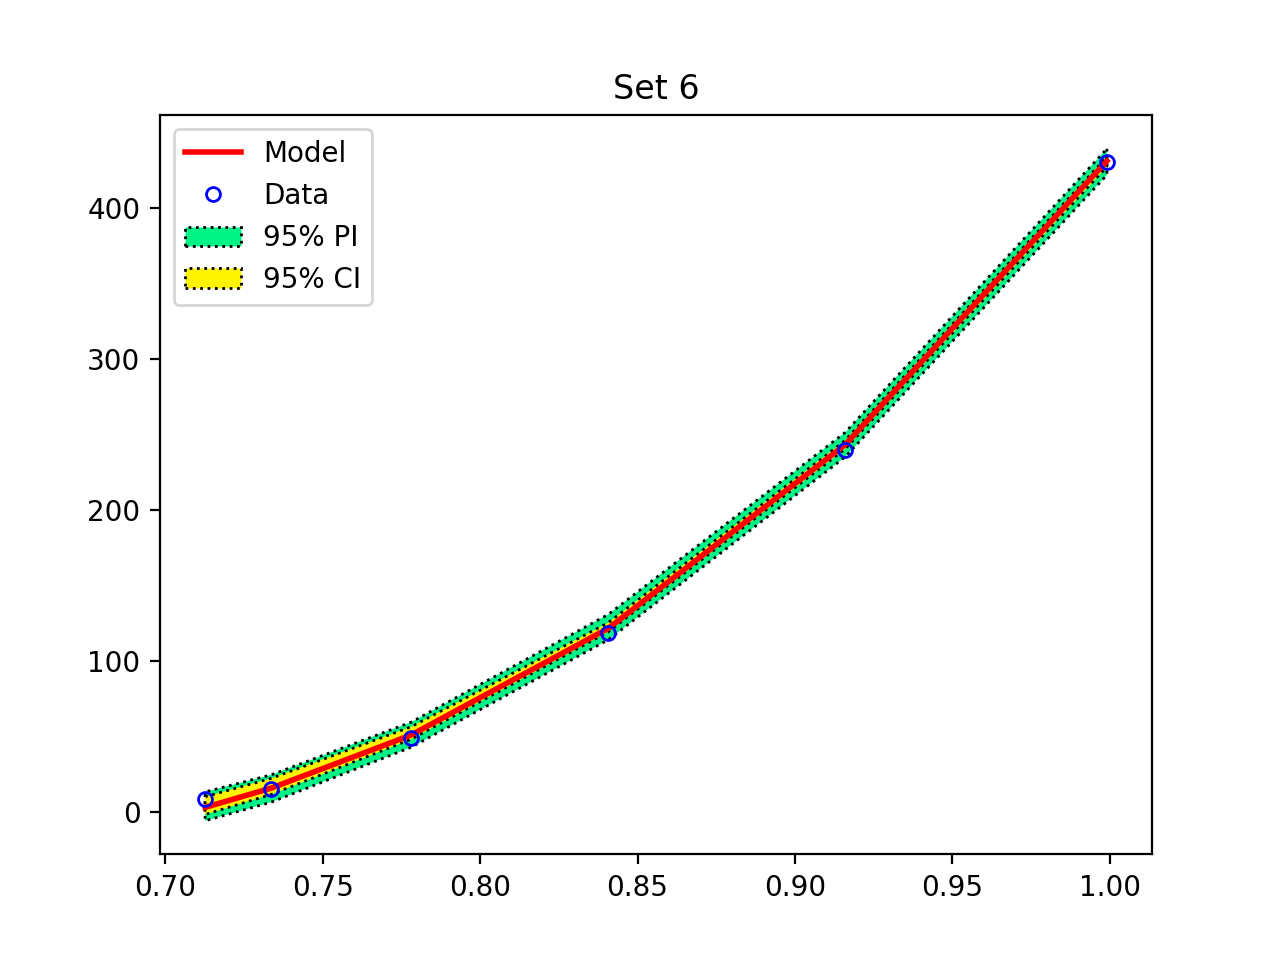

In [30]:
%matplotlib notebook
from pymcmcstat import propagation as up

for ii in range(len(polarization)):
    pdata = DataStructure()
    pdata.add_data_set(polarization[ii], energy[ii])
    intervals = up.calculate_intervals(chain, results, pdata,
                                    landau_energy,
                                    s2chain=s2chain,
                                    nsample=500, waitbar=True)
    if ii == 0:
        fig3, ax3 = up.plot_3d_intervals(intervals, pdata.xdata[0][:, 1::], pdata.ydata[0],
                                    limits=[95],
                                    adddata=True, addprediction=True, addcredible=True,
                                    addlegend=True, data_display=dict(marker='o'))
    else:
        fig3, ax3 = up.plot_3d_intervals(intervals, pdata.xdata[0][:, 1::], pdata.ydata[0],
                                    limits=[95], fig=fig3,
                                    adddata=True, addprediction=True, addcredible=True,
                                    addlegend=False, data_display=dict(marker='o'))
    fig, ax = up.plot_intervals(intervals,
                             np.linalg.norm(pdata.xdata[0][:, 1::], axis=1),
                             pdata.ydata[0],
                             limits=[95],
                             adddata=True, addprediction=True, addcredible=True,
                             addlegend=True, data_display=dict(marker='o', mfc='none'))
    ax.set_title(str('Set {}'.format(ii + 1)))
ax3.set_xlabel('$P_2$')
ax3.set_ylabel('$P_3$')
ax3.set_zlabel('$u$')
tmp = ax3.set_xlim([-0.1, 0.6])